# Modelling

## 0. Initialization

### 0.1. Environment

In [ ]:
import data.utils as utils

# Initialize environment.
%matplotlib inline
# %matplotlib notebook
%reload_ext autoreload
%autoreload 2

utils.init_environment()

### 0.2. Imports

In [ ]:
# Utilities
import math
import copy
import re
import time
import itertools
from IPython.display import display, HTML

# Local libraries
import data.query as dq

# Data manipulation
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Machine learning
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer

from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier #, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, recall_score, precision_score, f1_score, accuracy_score

from skmultiflow.trees import RegressionHoeffdingTree, RegressionHAT, HoeffdingTree, HAT

from lib.bagging import BaggingRegression

### 0.3. Settings

In [ ]:
# Data
random_seed=1234
DATE_FROM = '2010-01-01'
DATE_TO = '2017-12-31'
TEST_STATIONS = [
    5078,  # Ljubljanica (Moste)
#     5040,  # Ljubljanica (Kamin)
#     8080, # Soča (Kobarid) !
#     8180, # Soča (Solkan) !
#     8454,  # Cerknica
]
DROP_FEATURES = {
#     'day_time',
#     'precipitation',
#     'snow_accumulation',
#     'temperature_avg',
#     'temperature_min',
#     'temperature_max',
#     'cloud_cover_avg',
#     'cloud_cover_min',
#     'cloud_cover_max',
#     'dew_point_avg', 
#     'dew_point_min', 
#     'dew_point_max',
#     'humidity_avg',
#     'humidity_min',
#     'humidity_max',
#     'pressure_avg', 
#     'pressure_min', 
#     'pressure_max',
    'uv_index_avg', 
    'uv_index_min', 
    'uv_index_max',
#     'precipitation_probability_avg',
#     'precipitation_probability_min',
#     'precipitation_probability_max',
#     'precipitation_intensity_avg',
#     'precipitation_intensity_min',
#     'precipitation_intensity_max'
}
IMPUTATE = True

# Modelling types
MODEL_REG = 'regression'
MODEL_CLS = 'classification'

# Processing types
PROCESS_BAT = 'batch'
PROCESS_STR = 'stream'

# Prediction value type
PREDICT_ABS = 'absolute'
PREDICT_REL = 'relative'

# Methods
METHODS = {
    MODEL_REG: {
        PROCESS_BAT: {
            'LINR': {
                'name': 'Linear Regression',
                'class': LinearRegression,
                'params': {},
            },
            'DTR': {
                'name': 'Decision Trees',
                'method': DecisionTreeRegressor(random_state=random_seed),
                'scaler': None,
            },
            'RFR': {
                'name': 'Random Forest',
                'method': RandomForestRegressor(n_estimators=10, random_state=random_seed),
                'scaler': None,
            },
            'GBR': {
                'name': 'Gradient Boosting',
                'method': GradientBoostingRegressor(random_state=random_seed),
                'scaler': None,
            },
            'PLSR': {
                'name': 'PLS Regression',
                'class': PLSRegression,
                'params': {},
            },
            'ETR': {
                'name': 'Extra Trees',
                'method': ExtraTreeRegressor(random_state=random_seed),
                'scaler': None,
            },
            'SVR': {
                'name': 'SVR',
                'class': SVR,
                'params': {
                    'gamma': 'auto',
                },
                'scaler': {
                    'class': MinMaxScaler,
                },
            },
            'MLPR': {
                'name': 'Multi-Layer Perceptron',
                'method': MLPRegressor(random_state=random_seed),
                'scaler': MinMaxScaler(),
            },
            'KNR': {
                'name': 'k Nearest Neighbors',
                'class': KNeighborsRegressor,
                'params': {},
                'scaler': {
                    'class': MinMaxScaler,
                },
            },
        },
        PROCESS_STR: {
            'RHT': {
                'name': 'Hoeffding Tree',
                'class': RegressionHoeffdingTree,
                'params': {
                    'leaf_prediction': 'perceptron',
#                     'random_state': 0,
                }
            },
            'RHAT': {
                'name': 'Hoeffding Adaptive Tree',
                'class': RegressionHAT,
                'params': {
                    'leaf_prediction': 'perceptron',
#                     'random_state': 0,
                },
            },
            'BAGRHT': {
                'name': 'Bagging (Hoeffding Tree)',
                'class': BaggingRegression,
                'params': {
                    'base_estimator': {
                        'name': 'Hoeffding Tree',
                        'class': RegressionHoeffdingTree,
                        'params': {
                            'leaf_prediction': 'perceptron',
                        },
                    },
                },
            },
            'BAGRHAT': {
                'name': 'Bagging (Hoeffding Adaptive Tree)',
                'class': BaggingRegression,
                'params': {
                    'base_estimator': {
                        'class': RegressionHAT,
                        'params': {
                            'leaf_prediction': 'perceptron',
                        },
                    },
                },
            },
        }
    },
    MODEL_CLS: {
        PROCESS_BAT: {
            'LOGR': {
                'name': 'Logistic Regression',
                'method': LogisticRegression(solver = 'liblinear', multi_class='auto', random_state=random_seed),
                'scaler': None,
            },
            'DTC': {
                'name': 'Decision Tree',
                'method': DecisionTreeClassifier(random_state=random_seed),
                'scaler': None,
            },
            'ETC': {
                'name': 'Extra Tree',
                'method': ExtraTreeClassifier(random_state=random_seed),
                'scaler': None,
            },
            'RFC': {
                'name': 'Random Forest ',
                'method': RandomForestClassifier(n_estimators = 10, random_state=random_seed),
                'scaler': None,
            },
            'SVC': {
                'name': 'SVC',
                'method': SVC(gamma='auto', random_state=random_seed),
                'scaler': MinMaxScaler(),
            },
            'KNC': {
                'name': 'k Nearest Neighbors',
                'class': KNeighborsClassifier,
                'params': {},
                'scaler': {
                    'class': MinMaxScaler,
                },
            },
            'PERC': {
                'name': 'Perceptron',
                'method': Perceptron(random_state=random_seed),
                'scaler': MinMaxScaler(),
            },
            'MNB': {
                'name': 'Multinominal Naïve Bayes',
                'class': MultinomialNB,
                'params': {},
            },
            'GNB': {
                'name': 'Gaussian Naïve Bayes',
                'class': GaussianNB,
                'params': {},
            },
        },
        PROCESS_STR: {
            'HT': {
                'name': 'Hoeffding Tree',
                'class': HoeffdingTree,
                'params': {},
            },
            'HAT': {
                'name': 'Hoeffding Adaptive Tree',
                'class': HAT,
                'params': {},
            },
        }
    }
}

MAX_FEATURES = 120
HORIZON = 3
MAX_SHIFT = 20
MAX_AVERAGE = 20

# Testing
TEST_SIZE = 0.25
TEST_TRIALS = 5

# Evaluation
EVAL_SCORE = 'score'
EVAL_ERROR = 'error'
EVAL = {
    MODEL_REG: {
        EVAL_SCORE: {
            'class': r2_score,
            'params': {}
        }
    },
    MODEL_CLS: {
        EVAL_SCORE: {
            'class': f1_score,
            'params': {
                'average': 'macro'
            }
        }
    }
}


### 0.4. Utils

In [ ]:
def process_weather(dataset):
    if 'day_time' in dataset:
        dataset['day_time'] /= 3600
    

def imputate(df):
    """Interpolate given data frame.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Data frame.

    Returns
    -------
    pandas.DataFrame
        Data frame with interpolated missing values.
    
    """
    df0 = df.interpolate(method='spline', order=2)
    df0[df0.isna()] = 0.0
    return df0


def create_results_df(datasets):
    """Generate empty dataframe for evaluation results.
    
    Parameters
    ----------
    datasets : list[pandas.DataFrame]
        List of datasets.

    Returns
    -------
    pandas.Dataframe
        Empty data frame for evaluation results.

    """
    index = list(itertools.product(
                datasets.keys(),
                [PREDICT_ABS, PREDICT_REL],
                [MODEL_REG, MODEL_CLS],
                [PROCESS_BAT, PROCESS_STR]))
    extended_index = []
    columns=['Score', 'Score Min', 'Score Max']
    if HORIZON > 0:
        columns = ['Score', 'Score Min', 'Score Max', f'Score (h={HORIZON})', f'Score Min (h={HORIZON})', f'Score Max (h={HORIZON})', 'Learning Time', 'Predicting Time']
    else:
        columns = ['Score', 'Score Min', 'Score Max', 'Learning Time', 'Predicting Time']
    for t in index:
        for key, method in METHODS[t[2]][t[3]].items():
            m = method['class']()
            extended_index.append(t + (f'{type(m).__name__}[{key}]',))
    return pd.DataFrame(
        data=[],
        index=pd.MultiIndex.from_tuples(
            extended_index,
            names=['Station', 'Value', 'Modelling', 'Processing', 'Method']),
        columns=columns
    ).sort_index()


def get_range(min, max):
    """Get a range between `min` and `max` with predetermined step.

    Parameters
    ----------
    min : int
        Lower bound of a range.
        
    max : int
        Upper bound of a range.

    Returns
    -------
    list
        Rane of integers between given bounds.
    
    """
    r = range(min, max)
    r = []
    i = min
    while i <= max:
        r.append(i)
        e = math.floor(math.log10(i))
        d = 10 ** e
        if i < 10 ** (e + 1) / 2:
            d = math.ceil(d / 2)
        i += d
    return r


def shift_features(dataset, values, max_shift=MAX_SHIFT, horizon=HORIZON):
    days = get_range(1, max_shift)
    for feature_name in list(dataset.columns):
#         if feature_name[-4:] in ['_min', '_max']:
#             continue
        for i in days:
            if feature_name in values and i < horizon:
                continue
            dataset[f'{feature_name}_shift_{str(i)}d'] = dataset[feature_name].shift(i)


def average_features(dataset, values, max_average=MAX_AVERAGE):
    days = get_range(2, max_average)
    for feature_name in list(dataset.columns):
#         if feature_name[-4:] in ['_min', '_max']:
#             continue
        if feature_name in values:
            continue
        for i in days:
            dataset[f'{feature_name}_average_{str(i)}d'] = dataset[feature_name].rolling(i).sum() / i


def select_features(features, max_variations=3, max_features=100):
    feature_map = {}
    features.sort(key=lambda f: f[1], reverse=True)
    for feature_name, feature_score in features:
        feature_match = re.match(r'(.*)_\d+d', feature_name)
        if feature_match:
            feature_base = feature_match.group(1)
            if feature_base not in feature_map:
                feature_map[feature_base] = {
                    feature_name: feature_score
                }
            elif len(feature_map[feature_base].items()) < max_variations:
                feature_map[feature_base][feature_name] = feature_score
        else:
            feature_map[feature_name] = feature_score

    selected_features = []
    for key, value in feature_map.items():
        if isinstance(value, float):
            selected_features.append((key, value))
        else:
            for sub_key, sub_value in value.items():
                selected_features.append((sub_key, sub_value))
                
#     counters = {
#         'variation': {},
#         'base': {}
#     }
    
#     for feature_name, feature_score in features:
#         feature_match = re.match(r'(.*)_\d+d', feature_name)
#         if feature_match:

    selected_features.sort(key=lambda f: f[1], reverse=True)
    
    if len(selected_features) > max_features:
        selected_features = selected_features[:max_features]

    return selected_features


def filter_columns(dataset, columns):
    ds = pd.DataFrame()
    for col in columns:
        if col in dataset.columns:
            ds[col] = dataset[col]
    return ds


def discretize_abs(df):
    # TODO
    df = df / 10
    df = df.round(decimals=0)
    df = df * 10
    return df.astype(np.int)


def discretize_rel(df):
    # TODO
    df = df / 5
    df = df.round(decimals=0)
    df = df * 5
    return df.astype(np.int)


def save_figure(plt, file_name):
    plt.savefig(f'resources/{file_name}', dpi = 300, bbox_inches='tight')
    

def plot_corr(corr, corr_labels, size=6, file_name=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    im = plt.imshow(corr)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax)

    corr_ticks = range(len(corr_labels))

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(corr_labels)))
    ax.set_yticks(np.arange(len(corr_labels)))
    ax.set_xticklabels(corr_labels)
    ax.set_yticklabels(corr_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha='left', va='center', rotation_mode='anchor', 
             horizontalalignment='left',
             verticalalignment='top')
    
    if file_name:
        save_figure(plt, file_name)
    

def cluster_df(df, k=0.5):
    X = df.corr().values
    d = sch.distance.pdist(X)
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, k * d.max(), 'distance')
    columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
    df = df.reindex(columns, axis=1)
    return df



### 0.5. Initialization

In [ ]:
pd.set_option('display.max_rows', 5000)

## 1. Data preparation

In [ ]:
# Filter stations based on data availability.
stations = dq.filter_sw_stations(DATE_FROM, DATE_TO, 1.0)

# Remove lake stations...
redundant_stations = [3280, 3350]
stations = [s for s in stations if s not in redundant_stations]
print(f'Selected {len(stations)} stations.')

In [ ]:
# Additional filtering
if TEST_STATIONS:
    stations = TEST_STATIONS
station_sample = stations[0]

### 1.1. Watercourses data

In [ ]:
# Get water data.
water_dfs = {}
for station in stations:
    water_df = dq.get_sw_data(station, DATE_FROM, DATE_TO)
    
    # Imputate missing values.
    if IMPUTATE:
        water_df = imputate(water_df)
    water_dfs[station] = water_df

water_df_sample = water_dfs[station_sample]
water_df_sample

In [ ]:
# Plot water levels.
plt.figure(figsize=(13, 7))
plt.plot(water_df_sample.index.values, water_df_sample['level'])
plt.title(f'Water levels for station {station_sample} between {DATE_FROM[0:4]} and {DATE_TO[0:4]}')
plt.xlabel('date')
plt.ylabel('water level [cm]')
plt.tight_layout()
plt.show()

# Plot water level histogram.
plt.figure(figsize=(13, 7))
plt.hist(water_df_sample['level'])
plt.title(f'Water levels histogram for station {station_sample} between {DATE_FROM[0:4]} and {DATE_TO[0:4]}')
plt.xlabel('water level [cm]')
plt.ylabel('count')
plt.tight_layout()
plt.show()

### 1.2. Weather data

In [ ]:
# Get weather data.
weather_dfs = {}
for station in stations:
    weather_df = dq.get_sw_weather_data(station, DATE_FROM, DATE_TO)
    process_weather(weather_df)
    
    # Drop selected features.
    for drop_feature in DROP_FEATURES:
        weather_df.drop(drop_feature, 1, inplace=True)
        
    # Imputate missing values.
    if IMPUTATE:
        weather_df = imputate(weather_df)
    
    weather_dfs[station] = weather_df

weather_df_sample = weather_dfs[station_sample]
weather_df_sample

In [ ]:
# Plot weather data.
skip_list = ['day_time']
variations_map = {
    'avg': [1, 0],
    'min': [2, 2], 
    'max': [4, 2],
}
feature_variations = variations_map.keys()
for feature_name in weather_df_sample.columns.to_list():
    if feature_name in skip_list:
        continue
    
    plt.figure(figsize=(13, 7))
    plt.xlabel('date')
    plt.tight_layout()

    if feature_name[-3:] in feature_variations:
        plt.ylabel(feature_name[:-4])
        for fv in feature_variations:
            fvn = feature_name[:-3] + fv
            if fvn not in weather_df_sample.columns.to_list():
                continue
            skip_list.append(fvn)
            plt.plot(weather_df_sample.index.values, weather_df_sample[fvn], dashes=variations_map[fv], label=fv)
        #plt.ylabel(feature_name[:-3] + 'avg')
        #plt.plot(weather_df_sample.index.values, weather_df_sample[feature_name[:-3] + 'avg'])
        plt.legend()
    else:
        plt.ylabel(feature_name)
        plt.plot(weather_df_sample.index.values, weather_df_sample[feature_name], label=feature_name)
    
    plt.show()

### 1.3. Data fusion

In [ ]:
datasets = {}
for station, water_df, weather_df in zip(water_dfs.keys(), water_dfs.values(), weather_dfs.values()):
    water_df['level_diff'] = water_df['level'] - water_df['level'].shift(1)
    datasets[station] = pd.concat([water_df, weather_df], axis=1)[1:]

dataset_sample = datasets[station_sample]
dataset_sample

## 2. Feature ingeneering

In [ ]:
# Show scatter plot for each feature.
plt.figure(figsize=(17, 37))
for index, feature_name in enumerate(dataset_sample.columns[2:]):
    plt.subplot(9, 3, index + 1)
    plt.scatter(dataset_sample[feature_name], dataset_sample['level'])
    plt.xlabel(feature_name)
    plt.ylabel('water level [cm]')

In [ ]:
ds = copy.deepcopy(dataset_sample.iloc[:, 1:])
corr = ds.corr()
corr

In [ ]:
# Plot correlation matrix.
plot_corr(corr, ds.columns, size=6, file_name='correlatin_matrix_basic.png')

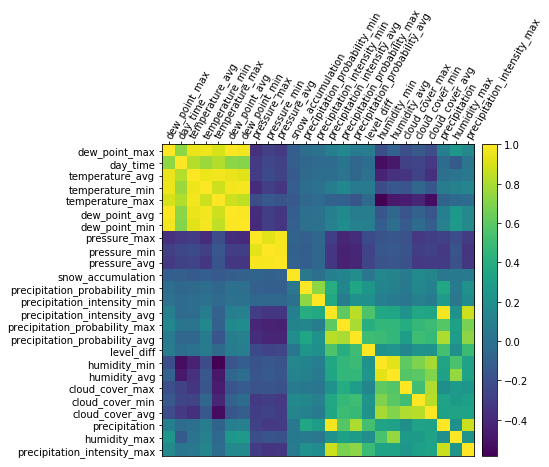

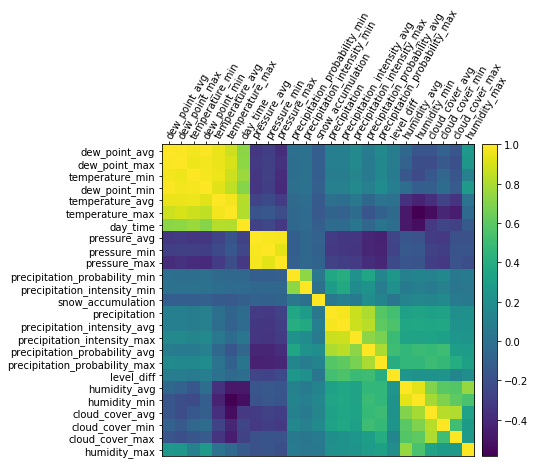

In [449]:
# Plot clustered correlation matrix.
dsc = cluster_df(ds)
plot_corr(dsc.corr(), dsc.columns, size=6, file_name='correlatin_matrix_basic_clusterred.png')

dsc2 = cluster_df(ds, k=0.0)
plot_corr(dsc2.corr(), dsc2.columns, size=6, file_name='correlatin_matrix_basic_clusterred2.png')

In [ ]:
corr.sort_values(['level_diff'], ascending = False)

In [ ]:
# Drop correlated features.
# ds.drop('temperature_avg', 1, inplace=True)
# ds.drop('temperature_min', 1, inplace=True)
# ds.drop('temperature_max', 1, inplace=True)
ds.drop('dew_point_avg', 1, inplace=True)
ds.drop('dew_point_min', 1, inplace=True)
ds.drop('dew_point_max', 1, inplace=True)
ds.drop('pressure_avg', 1, inplace=True)
ds.drop('pressure_min', 1, inplace=True)
ds.drop('pressure_max', 1, inplace=True)
ds.shape

In [ ]:
# Add new shifted and averaged features.
shift_features(ds, ['level', 'level_diff'])
average_features(ds, ['level', 'level_diff'])

ds.columns

In [ ]:
# Calculate corelation matrix.
corr = ds.corr()
corr

In [ ]:
# Sort correlated features.
corr.sort_values(['level_diff'], ascending = False)['level_diff']

In [ ]:
# Manual feture selection:
base_feature_names = [
    'day_time',
    'precipitation', # !
    'snow_accumulation',
    'temperature_avg',
    'temperature_min',
    'temperature_max',
    'cloud_cover_avg',
    'cloud_cover_min',
    'cloud_cover_max',
#     'dew_point_avg',
#     'dew_point_min',
#     'dew_point_max',
    'humidity_avg', # !
    'humidity_min',
    'humidity_max',
#     'pressure_avg',
#     'pressure_min',
#     'pressure_max',
#     'uv_index_avg',
#     'uv_index_min',
#     'uv_index_max',
    'precipitation_probability_avg', # !
    'precipitation_probability_min', # !
    'precipitation_probability_max', # !
    'precipitation_intensity_avg',
    'precipitation_intensity_min',
    'precipitation_intensity_max', # !
]

level_feature_names = [
#     'level'
    
    f'level_shift_{HORIZON}d',
    f'level_shift_{HORIZON + 1}d',
    f'level_shift_{HORIZON + 2}d',
#     'level_shift_80d',
#     'level_shift_25d',
#     'level_shift_24d',
#     'level_shift_16d',
    
#     'level_shift_3d_average_2d',
#     'level_shift_3d_average_3d',
#     'level_shift_3d_average_4d',
#     'level_shift_70d_average_6d',
#     'level_shift_70d_average_7d',
#     'level_shift_70d_average_5d',
#     'level_shift_70d_average_10d',
#     'level_shift_70d_average_11d',
    
#     'level_diff',
        
#     'level_diff_shift_{HORIZON}d',
#     'level_diff_shift_{HORIZON + 1}d',
#     'level_diff_shift_{HORIZON + 2}d',
#     'level_diff_shift_10d',
#     'level_diff_shift_100d',
#     'level_diff_shift_12d',
#     'level_diff_shift_80d',
#     'level_diff_shift_19d',
    
#     'level_diff_shift_{HORIZON}d_average_2d',
#     'level_diff_shift_{HORIZON}d_average_3d',
#     'level_diff_shift_{HORIZON}d_average_4d',
#     'level_diff_shift_80d_average_21d',
#     'level_diff_shift_80d_average_22d',
#     'level_diff_shift_80d_average_10d',
#     'level_diff_shift_80d_average_11d',
#     'level_diff_shift_80d_average_20d',
] if HORIZON > 0 else []

manual_feature_names = base_feature_names + level_feature_names + [
    
#     'precipitation_intensity_avg_average_2d',
#     'precipitation_average_2d',
#     'precipitation_intensity_max_average_2d',
#     'precipitation_probability_avg_average_2d',
#     'precipitation_intensity_avg',
#     'precipitation_intensity_avg_shift_1d',
#     'precipitation_shift_1d',
#     'precipitation_intensity_avg_average_3d',
#     'precipitation_probability_avg_shift_1d',
#     'precipitation_average_3d',
#     'precipitation_intensity_max_shift_1d',
#     'precipitation_probability_max_average_2d',
#     'precipitation_probability_avg_average_3d',
#     'precipitation_intensity_max_average_3d',
#     'precipitation_probability_max_shift_1d',
#     'precipitation_probability_max_average_3d',
    
# #     'precipitation_intensity_avg_average_4d',
# #     'precipitation_average_4d',
# #     'precipitation_probability_avg_average_4d',
# #     'precipitation_probability_min_average_2d',
# #     'precipitation_intensity_max_average_4d',
# #     'precipitation_probability_avg_shift_1d_average_2d',
# #     'precipitation_intensity_avg_shift_1d_average_2d',
# #     'precipitation_shift_1d_average_2d',
# #     'precipitation_intensity_max_shift_1d_average_2d',
# #     'precipitation_probability_max_average_4d',
# #     'precipitation_intensity_avg_average_5d',
#     'cloud_cover_min_average_2d',
# #     'precipitation_average_5d',
# #     'precipitation_probability_min_average_3d',
# #     'precipitation_probability_max_shift_1d_average_2d',
# #     'precipitation_intensity_min_average_2d',
#     'humidity_min_average_2d',
#     'cloud_cover_avg_average_2d',
#     'cloud_cover_min_shift_1d',
# #     'precipitation_probability_avg_average_5d',
# #     'precipitation_intensity_max_average_5d',
#     'humidity_min_shift_1d',
#     'humidity_avg_average_2d',
    
    'precipitation_average_2d',
    'precipitation_average_3d',
    'precipitation_average_4d',
    'precipitation_shift_1d',
    'precipitation_shift_1d_average_2d',
    'precipitation_shift_1d_average_3d',

    'precipitation_intensity_avg_average_2d',
    'precipitation_intensity_avg_average_3d',
    'precipitation_intensity_avg_average_4d',
    'precipitation_intensity_avg_shift_1d',
    'precipitation_intensity_avg_shift_1d_average_2d',
    'precipitation_intensity_avg_shift_1d_average_3d',

    'precipitation_probability_avg_average_2d',
    'precipitation_probability_avg_average_3d',
    'precipitation_probability_avg_average_4d',
    'precipitation_probability_avg_shift_1d',
    'precipitation_probability_avg_shift_1d_average_2d',
    'precipitation_probability_avg_shift_1d_average_3d',

    'cloud_cover_avg_average_2d',
    'cloud_cover_avg_average_3d',
    'cloud_cover_avg_average_4d',
    'cloud_cover_avg_shift_1d',
    'cloud_cover_avg_shift_1d_average_2d',
    'cloud_cover_avg_shift_1d_average_3d',

    'humidity_avg_average_2d',
    'humidity_avg_average_3d',
    'humidity_avg_average_4d',
    'humidity_avg_shift_1d',
    'humidity_avg_shift_1d_average_2d',
    'humidity_avg_shift_1d_average_3d',
    
    'snow_accumulation_shift_9d',
    'snow_accumulation_shift_7d_average_4d',
    'snow_accumulation_shift_7d_average_2d',
]

len(manual_feature_names), manual_feature_names

In [ ]:
# Automatic feature selection:
min_row = MAX_SHIFT + MAX_AVERAGE
X = ds.iloc[min_row:, 2:].values.astype(float)
y = ds['level_diff'].iloc[min_row:].values.astype(float)
feature_selector = SelectKBest(score_func=f_regression, k=MAX_FEATURES)
feature_model = feature_selector.fit(X, y)
indices = feature_model.scores_.argsort()[-MAX_FEATURES:][::-1]
auto_feature_names = list(ds.columns[2:][indices])

len(auto_feature_names), auto_feature_names

In [ ]:
# Plot example of features correlated with water level change.
fig, ax = plt.subplots()
fig.autofmt_xdate()
fig.set_size_inches(10, 5)
col_size = 500
ax.plot(range(col_size), ds[:col_size]['level_diff'] / np.max(np.abs(ds[:col_size]['level_diff']),axis=0), label="Water level change");
ax.plot(range(col_size), ds[:col_size]['precipitation_average_3d'] / np.max(np.abs(ds[:col_size]['precipitation_average_3d']),axis=0), label="Precipitation avg. (3d)");
ax.plot(range(col_size), ds[:col_size]['cloud_cover_avg_average_4d'] / np.max(np.abs(ds[:col_size]['cloud_cover_avg_average_4d']),axis=0), label="Cloud cover avg. (4d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
save_figure(plt, 'feature_value_correlation.png')
plt.show()

In [ ]:
# Plot highly correlated features.
fig, ax = plt.subplots()
fig.autofmt_xdate()
fig.set_size_inches(10, 5)
ax.plot(dataset_sample.index, dataset_sample.loc[:, 'temperature_avg'], label='Temperature avg.')
ax.plot(dataset_sample.index, dataset_sample.loc[:, 'dew_point_avg'], label='Dew point avg.')
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Date')
plt.ylabel('Value')
save_figure(plt, 'features_correlation.png')
plt.show()


## 3. Modelling

In [ ]:
for key, dataset in datasets.items():
    dataset.drop('dew_point_avg', 1, inplace=True)
    dataset.drop('dew_point_min', 1, inplace=True)
    dataset.drop('dew_point_max', 1, inplace=True)
    dataset.drop('pressure_avg', 1, inplace=True)
    dataset.drop('pressure_min', 1, inplace=True)
    dataset.drop('pressure_max', 1, inplace=True)

    shift_features(dataset, ['level', 'level_diff'])
    average_features(dataset, ['level', 'level_diff'])
    
    min_row = MAX_SHIFT + MAX_AVERAGE
    datasets[key] = dataset.iloc[min_row:, :]

In [ ]:

results = create_results_df(datasets)

# 1. Run tests over all datasets:
# ===============================
for station_id, dataset in datasets.items():

    # 2. Run tests for absolute water level and water level change:
    # =============================================================
    for prediction_type in [PREDICT_REL]: # [PREDICT_ABS, PREDICT_REL]:

        # 3. Run tests for regression and classification:
        # ===============================================
        for modelling_type in [MODEL_REG]: # [MODEL_REG, MODEL_CLS]:
                
            # Prepare dataset.
            X = dataset.iloc[:, 2:]
            # X = X.values.astype(float)
            print(f'ALL FEATURES: {len(X.iloc[0])}')

            # Set dependent variable.
            if prediction_type == PREDICT_ABS:
                y = dataset['level']
            else:
                y = dataset['level_diff']
                
            # Discretize if necessary.
            if modelling_type == MODEL_CLS:
                y = discretize(y)

            y = y.values.astype(float)

            # Select features.
            feature_model = SelectKBest(score_func=f_regression, k='all').fit(X.values.astype(float), y)
            feature_indices = feature_model.scores_.argsort()[-MAX_FEATURES:][::-1]
            features = [(dataset.columns[2:][i], feature_model.scores_[i]) for i in feature_indices]
            selected_features = features[:54]
#             selected_features = select_features(features, max_variations=2, max_features=54)
            
#             selected_features.sort(key=lambda f: f[0])
#             print(f'SELECTED FEATURES[{len(selected_features)}]:')
#             for feature_name, feature_score in selected_features:
#                 print(feature_name, round(feature_score, 2))
                
            feature_names = [f[0] for f in selected_features]
            feature_names = list(set(base_feature_names + level_feature_names + feature_names))
#             feature_names = manual_feature_names
            X = filter_columns(X, feature_names)
#             display(HTML(X.to_html()))
#             X[X.abs() < 0.001] = 0
            X = X.values.astype(float)
            
            print(f'SELECTED FEATURES: {len(feature_names)}')
            feature_names.sort()
            for feature_name in feature_names:
                print(feature_name)
            

            # 4. Run test for batch and stream models:
            # ===========================================
            for processing_type in [PROCESS_BAT, PROCESS_STR]:
                
                # Pick methods and scores.
                methods = METHODS[modelling_type][processing_type]
                eval_score = EVAL[modelling_type][EVAL_SCORE]


                # 5. Run tests for all selected methods:
                # =====================================
                for key, method in methods.items():

                    # Scale features.
                    scaler = method.get('scaler')
                    if scaler:
                        scaler = scaler['class'](**scaler.get('params', {}))
                        X_tt = scaler.fit_transform(X)
                    else:
                        X_tt = X
                    
                    # Split dataset.
                    X_train, X_test, y_train, y_test = train_test_split(X_tt, y, test_size=TEST_SIZE, shuffle=False, stratify=None)
                    y_test_abs = dataset['level'].values.astype(float)[-len(y_test):]
                    predicted = np.zeros(len(y_test))
                    predicted_abs_h = np.zeros(len(y_test))
                    
                    fit_time = 0.0
                    predict_time = 0.0
                    score = 0.0
                    score_min = float('inf')
                    score_max = float('-inf')
                    score_abs = 0.0
                    score_abs_min = float('inf')
                    score_abs_max = float('-inf')
                    
                    
                    # print(type(m).__name__)
                    method_name = ''
                    for i in range(TEST_TRIALS):
                        params = method.get('params', {}).copy()
                        base_estimator = params.get('base_estimator')
                        if (base_estimator):
                            params['base_estimator'] = base_estimator['class'](**base_estimator.get('params', {}))
                        m = method['class'](**params)
                        
                        # Learn.
                        t = time.time()
                        m.fit(X_train, y_train)
                        fit_time += time.time() - t

                        # Predict.
                        t = time.time()
                        y_predicted = m.predict(X_test)
                        predict_time += time.time() - t
                        
                        if y_predicted.ndim > 1:
                            y_predicted = np.squeeze(y_predicted)

                        predicted += y_predicted
                        
                        # Evaluate.
                        current_score = eval_score['class'](y_test, y_predicted, **eval_score.get('params', {}))
                        score += current_score
                        score_min = min(current_score, score_min)
                        score_max = max(current_score, score_max)
                        
                        if HORIZON > 0:
                            h = HORIZON
                            y_predicted_abs_h = np.zeros(len(y_test_abs))
                            test_len = len(y_test_abs)
                            for i, abs_val in enumerate(y_test_abs):
                                if i + h >= test_len:
                                    break;
                                y_predicted_abs_h[i + h] = abs_val + sum(y_predicted[i:i + h])

                            predicted_abs_h += y_predicted_abs_h

                            current_score_abs = eval_score['class'](y_test_abs[h:], y_predicted_abs_h[h:], **eval_score.get('params', {}))
                            score_abs += current_score_abs
                            score_abs_min = min(current_score_abs, score_abs_min)
                            score_abs_max = max(current_score_abs, score_abs_max)

                    # Store results.
                    method_name = f'{method["class"].__name__}[{key}]'
                    index = (station_id, prediction_type, modelling_type, processing_type, method_name)
                    results.loc[index, 'Score'] = score / TEST_TRIALS
                    results.loc[index, 'Score Min'] = score_min
                    results.loc[index, 'Score Max'] = score_max
                    results.loc[index, 'Learning Time'] = fit_time / TEST_TRIALS
                    results.loc[index, 'Predicting Time'] = predict_time / TEST_TRIALS
                    if HORIZON > 0:
                        results.loc[index, f'Score (h={HORIZON})'] = score_abs / TEST_TRIALS
                        results.loc[index, f'Score Min (h={HORIZON})'] = score_abs_min
                        results.loc[index, f'Score Max (h={HORIZON})'] = score_abs_max
                        predicted_abs_h /= TEST_TRIALS

                    predicted /= TEST_TRIALS
                    days_len = 350 # len(y_test)
                    days = list(range(days_len))

                    # Plot predicted value differences and real value differences.
                    fig, ax = plt.subplots()
                    fig.set_size_inches(10, 5)
                    ax.plot(days, y_test[:days_len], label="True value")
                    ax.plot(days, predicted[:days_len], label="Prediction")
                    ax.legend(loc=1, borderaxespad=1)
                    plt.xlabel('Time (days)')
                    plt.ylabel('Water level change (cm)')
                    plt.title(method['name'])
                    save_figure(plt, f'diff_{method_name}.png')
                    plt.show()

                    # Plot predicted values and real values.
                    predicted_abs = [y_test_abs[0]]
                    for n, val in enumerate(predicted[1:]):
                        predicted_abs.append(predicted_abs[n] + val)

                    fig, ax = plt.subplots() 
                    fig.set_size_inches(10, 5)
                    ax.plot(days, y_test_abs[:days_len], label="True value")
                    ax.plot(days, predicted_abs[:days_len], label="Prediction")
                    ax.legend(loc=1, borderaxespad=1)
                    plt.xlabel('Time (days)')
                    plt.ylabel('Water level (cm)')
                    plt.title(method['name'])
                    save_figure(plt, f'sum_{method_name}.png')
                    plt.show()
                    
                    if HORIZON > 0:
                        # Plot predicted values with prediction horizon and real values.
                        h = HORIZON
                        days_len_max = min(len(predicted_abs_h) - h, days_len)
                        fig, ax = plt.subplots() 
                        fig.set_size_inches(10, 5)
                        ax.plot(days[:days_len_max], y_test_abs[h:days_len_max + h], label="True value")
                        ax.plot(days[:days_len_max], predicted_abs_h[h:days_len_max + h], label="Prediction")
                        ax.legend(loc=1, borderaxespad=1)
                        plt.xlabel('Time (days)')
                        plt.ylabel('Water level (cm)')
                        plt.title(f"{method['name']} (h={HORIZON})")
                        save_figure(plt, f'sum_h{HORIZON}_{method_name}.png')
                        plt.show()

                        # Plot R² score as a function of prediction horizon
#                         horizons = range(1, 11)
#                         scores = []
#                         for h in horizons:
#                             y_predicted_abs_h = np.zeros(len(y_test_abs))
#                             test_len = len(y_test_abs)
#                             for i, abs_val in enumerate(y_test_abs):
#                                 if i + h >= test_len:
#                                     break;
#                                 y_predicted_abs_h[i + h] = abs_val + sum(y_predicted[i:i + h])

#                             scores.append(eval_score['class'](y_test_abs[h:], y_predicted_abs_h[h:], **eval_score.get('params', {}))

#                         fig, ax = plt.subplots() 
#                         fig.set_size_inches(10, 5)
#                         ax.plot(horizons, scores, label="True value")
#                         ax.legend(loc=1, borderaxespad=1)
#                         plt.xlabel('Prediction horizon (days)')
#                         plt.ylabel('R²')
#                         plt.title(method['name'])
#                         save_figure(plt, f'hor_{method_name}.png')
#                         plt.show()
                    
            print(f'{station_id} > {prediction_type} > {modelling_type}:'.upper())
            df = results.loc[(station_id, prediction_type, modelling_type)]
            # df.sort_values(by=['Score'], ascending=False)
            display(HTML(df.to_html()))
            print('')

# results

In [ ]:
# Save results.
results.to_pickle('resources/results.pkl')

In [ ]:
# Plot score vs time.
for processing_type in [PROCESS_BAT, PROCESS_STR]:
    df = results.loc[(5078, 'relative', 'regression', processing_type)]
    x = df.loc[:, 'Learning Time']
    y = df.loc[:, 'Score']
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'bx', markersize=12)
    plt.xlabel('Time [s]')
    plt.ylabel('R² score')
    
    legend = []
    
    for i, method_name in enumerate(df.index.values):
        method_name = method_name[:-1].split('[')
        plt.annotate(method_name[1], (x.iloc[i], y.iloc[i]), fontsize=10)
        legend.append(f'{method_name[1]} - {method_name[0]}')
        
    save_figure(plt, f'time_scores_{processing_type}.png')
    
    plt.show()
    
    for l in legend:
        print(l)

In [463]:
# Load results.
results_loaded = pd.read_pickle('resources/results.pkl')
results_loaded

Score  \
Station Value    Modelling      Processing Method                                      
5078    absolute classification batch      DecisionTreeClassifier[DTC]           NaN   
                                           ExtraTreeClassifier[ETC]              NaN   
                                           GaussianNB[GNB]                       NaN   
                                           KNeighborsClassifier[KNC]             NaN   
                                           LogisticRegression[LOGR]              NaN   
                                           MultinomialNB[MNB]                    NaN   
                                           Perceptron[PERC]                      NaN   
                                           RandomForestClassifier[RFC]           NaN   
                                           SVC[SVC]                              NaN   
                                stream     HAT[HAT]                              NaN   
                                           HoeffdingTree[HT]                     NaN   
                 regression     batch      DecisionTreeRegressor[DTR]            NaN   
                                           ExtraTreeRegressor[ETR]               NaN   
                                           GradientBoostingRegressor[GBR]        NaN   
                                           KNeighborsRegressor[KNR]              NaN   
                                           LinearRegression[LINR]                NaN   
                                           MLPRegressor[MLPR]                    NaN   
                                           PLSRegression[PLSR]                   NaN   
                                           RandomForestRegressor[RFR]            NaN   
                                           SVR[SVR]                              NaN   
                                stream     BaggingRegression[BAGRHAT]            NaN   
                                           BaggingRegression[BAGRHT]             NaN   
                                           RegressionHAT[RHAT]                   NaN   
                                           RegressionHoeffdingTree[RHT]          NaN   
        relative classification batch      DecisionTreeClassifier[DTC]           NaN   
                                           ExtraTreeClassifier[ETC]              NaN   
                                           GaussianNB[GNB]                       NaN   
                                           KNeighborsClassifier[KNC]             NaN   
                                           LogisticRegression[LOGR]              NaN   
                                           MultinomialNB[MNB]                    NaN   
                                           Perceptron[PERC]                      NaN   
                                           RandomForestClassifier[RFC]           NaN   
                                           SVC[SVC]                              NaN   
                                stream     HAT[HAT]                              NaN   
                                           HoeffdingTree[HT]                     NaN   
                 regression     batch      DecisionTreeRegressor[DTR]       0.153217   
                                           ExtraTreeRegressor[ETR]         0.0384517   
                                           GradientBoostingRegressor[GBR]    0.63137   
                                           KNeighborsRegressor[KNR]         0.520046   
                                           LinearRegression[LINR]           0.616623   
                                           MLPRegressor[MLPR]               0.633336   
                                           PLSRegression[PLSR]              0.587446   
                                           RandomForestRegressor[RFR]       0.544555   
                                           SVR[SVR]                          0.16649   
                               